## Preprocess dataset

In [1]:
import numpy as np
from scipy.stats import gaussian_kde
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
import seaborn as sns

In [110]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [111]:
all_pixels = x_train.flatten()
print(all_pixels.shape)
np.random.seed(42)
np.random.shuffle(all_pixels)
some_pixels = all_pixels[:10000]

(47040000,)


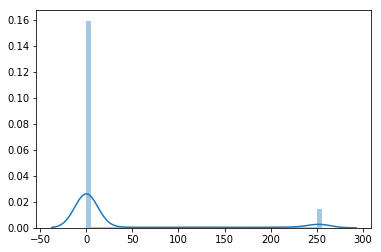

In [113]:
sns.distplot(some_pixels)

In [112]:
x_train[x_train < 100] = 0
x_train[x_train > 150] = 1
x_train[np.logical_and(x_train >= 100, x_train <= 150)] = 0

## Prior probabilities

From Bishop 1995 (Page 17): 
> If we were forced to classify a new character without being allowed to see the corresponding image, then the best we can do is to assign it to the class having the higher prior probability.

Purposefully make the two classes imbalanced to create uneven prior probabilities:

In [312]:
print(len(x_train[y_train == 1]))
print(len(x_train[y_train == 7]))

6742
6265


In [369]:
ones = x_train[y_train == 1][:3000]
sevens = x_train[y_train == 7][:2000]

Create training set and testing set:

In [370]:
def train_test_split(items, p=0.9, seed=42):
    num_items = len(items)
    return items[:int(p * num_items)], items[int(p * num_items):]

In [371]:
ones_train, ones_test = train_test_split(ones)
sevens_train, sevens_test = train_test_split(sevens)

In [372]:
print(len(ones_train), len(ones_test), len(sevens_train), len(sevens_test))

2700 300 1800 200


Compute prior probabilities:

In [373]:
num_digits = len(ones_train) + len(sevens_train)

In [374]:
P_C1 = len(ones_train) / num_digits
P_C2 = len(sevens_train) / num_digits

Let $C_1$ denotes the "1" class and $C_2$ denotes the "7" class:

In [375]:
print(r'Prior probability P(C_1) =', P_C1)
print(r'Prior probability P(C_2) =', P_C2)

Prior probability P(C_1) = 0.6
Prior probability P(C_2) = 0.4


## Class-conditioned probabilities

In [376]:
def get_height_weight_ratio(digit):
    leftmost_index, rightmost_index, top_index, bottom_index = 27, 0, 27, 0
    for i, row in enumerate(digit):
        if 1 in row:

            if i < top_index: top_index = i  # capture the topmost one
            elif i > bottom_index: bottom_index = i  # capture the bottommost one afterwards

            index_of_the_first_one = np.argmax(row)
            index_of_the_last_one = 27 - np.argmax(np.flip(row))
            if index_of_the_first_one < leftmost_index: leftmost_index = index_of_the_first_one
            if index_of_the_last_one > rightmost_index: rightmost_index = index_of_the_last_one

    return (bottom_index - top_index) / (rightmost_index - leftmost_index)

In [377]:
def get_height_weight_ratios(array_of_digits):
    ratios = []
    for digit in array_of_digits:
        ratios.append(get_height_weight_ratio(digit))
    return ratios

In [378]:
ones_train_ratios = get_height_weight_ratios(ones_train)
sevens_train_ratios = get_height_weight_ratios(sevens_train)

The overlap of the two distributions emphasizes the probabilitistic nature of pattern recognition:

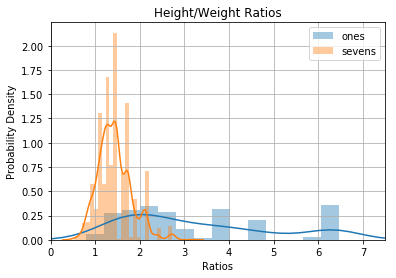

In [379]:
sns.distplot(ones_train_ratios, label='ones')
sns.distplot(sevens_train_ratios, label='sevens')
plt.title("Height/Weight Ratios")
plt.xlabel('Ratios'); plt.ylabel('Probability Density')
plt.xlim(0, 7.5); plt.grid(); plt.legend()
plt.show()

Scipy.stats' `guassian_kde` allows class-conditional probability densities to be computed directly.

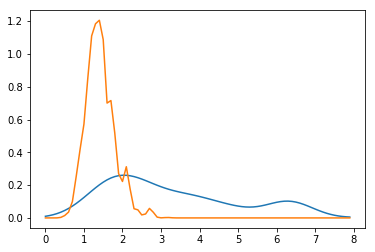

In [380]:
ones_train_ratios_kde = gaussian_kde(ones_train_ratios)  # probability density function of feature given C1
sevens_train_ratios_kde = gaussian_kde(sevens_train_ratios)  # probability density function of feature given C2

xs = np.arange(0, 8, 0.1)

ones_train_ys = ones_train_ratios_kde(xs)
sevens_train_ys = sevens_train_ratios_kde(xs)

sns.lineplot(xs, ones_train_ys)
sns.lineplot(xs, sevens_train_ys)

## Inference - posterior probabilities

In [381]:
def bayesian_classifier(X):
    
    feature = get_height_weight_ratio(X)
    
    likelihood_X_given_C1 = ones_train_ratios_kde(feature)
    posterior_C1_given_X = likelihood_X_given_C1 * P_C1

    likelihood_X_given_C2 = sevens_train_ratios_kde(feature)
    posterior_C2_given_X = likelihood_X_given_C2 * P_C2
    
    normalization_factor = posterior_C1_given_X + posterior_C2_given_X
    
    P_C1_given_X = posterior_C1_given_X / normalization_factor
    P_C2_given_X = posterior_C2_given_X / normalization_factor
    
    return 1 if P_C1_given_X > P_C2_given_X else 2

In [382]:
def accuracy(digits, label):
    predictions = np.array([bayesian_classifier(digit) for digit in digits])
    acc = np.mean(predictions == label)
    return acc

In [383]:
num_digits_test = len(ones_test) + len(sevens_test)
acc_test = (accuracy(ones_test, label=1) * len(ones_test) + accuracy(sevens_test, label=2) * len(sevens_test)) / num_digits_test

**Observation.** The classifier accuracy wins over prior probability more when the dataset is more balanced.
- Question: what if the likelihood divide is against the prior probability?

In [384]:
print(acc_test)
print(np.max([P_C1, P_C2]))

0.866
0.6


In [387]:
assert acc_test >= np.max([P_C1, P_C2])

## More decision criteria